<a href="https://colab.research.google.com/github/bygencer3/ErdincGencer_Odev_254329028-/blob/main/Yapay_Sinir_Aglari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Veri Seti İlk 5 Satır:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst pe

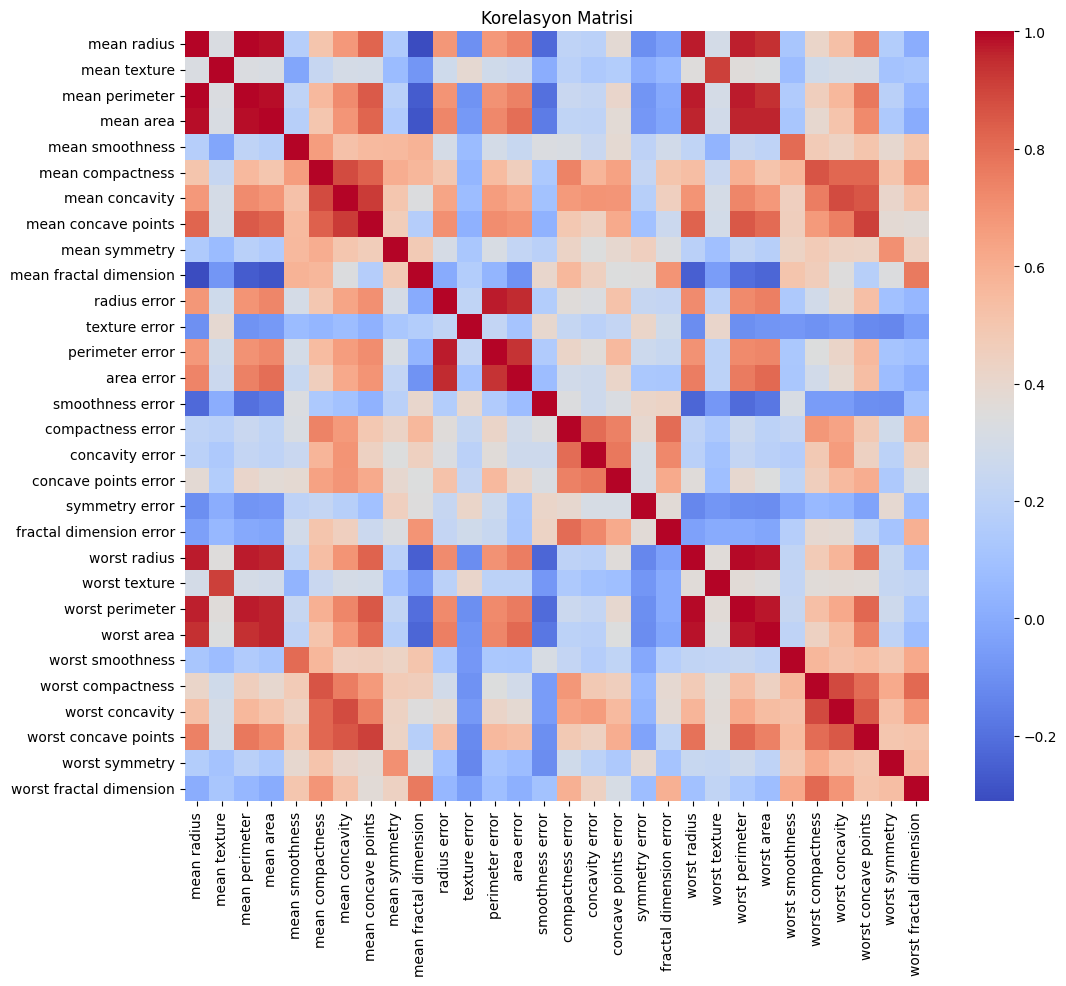

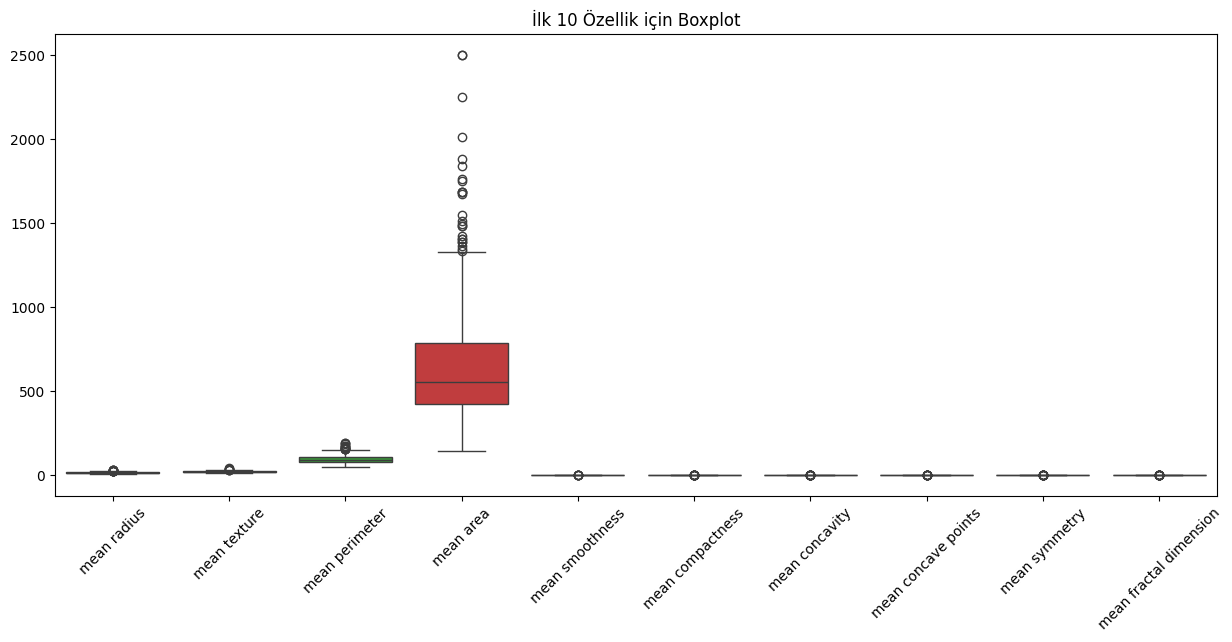


Veri Boyutları:
Train: (398, 30)
Val: (57, 30)
Test: (114, 30)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- 1. Veri Setinin Yüklenmesi ---
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# İlk 5 satır
print("Veri Seti İlk 5 Satır:")
print(X.head())

# --- 2. Veri Kalite Kontrolleri ---
print("\n--- Eksik Değer Analizi ---")
print(X.isnull().sum().sum()) # 0 ise eksik yok demektir.

# 2.2 Aykırı Değer (Outlier) Analizi - IQR Yöntemi (Örnek olarak 'mean radius' için)
Q1 = X['mean radius'].quantile(0.25)
Q3 = X['mean radius'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = X[(X['mean radius'] < lower_bound) | (X['mean radius'] > upper_bound)]
print(f"\n'mean radius' için Aykırı Değer Sayısı: {len(outliers)}")

# 2.3 Veri Tipi
print("\nVeri Tipleri:")
print(X.dtypes.value_counts())

# --- 3. Keşifsel Veri Analizi (EDA) ---
# 3.1 İstatistiksel Özellikler
print("\nİstatistiksel Özet:")
print(X.describe().T[['mean', '50%', 'min', 'max', 'std']]) # 50% = Median

# 3.2 Korelasyon Matrisi
plt.figure(figsize=(12, 10))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False) # Annot=False okunaklılık için
plt.title("Korelasyon Matrisi")
plt.show()

# Yüksek korelasyonlu çiftleri bulma
# (Bu kısım yorumlarınızda kullanılacak: örn. radius ve perimeter çok yüksek korelasyonludur)

# 3.3 Boxplot (Örnek ilk 10 özellik için)
plt.figure(figsize=(15, 6))
sns.boxplot(data=X.iloc[:, :10])
plt.xticks(rotation=45)
plt.title("İlk 10 Özellik için Boxplot")
plt.show()

# --- 4. Veri Ölçeklendirme ---
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_np, columns=X.columns)

# --- 5. Veri Setinin Bölünmesi ---
# Hedef: %70 Train, %10 Val, %20 Test
# Önce %20 Test ayıralım, kalanı (%80) Train+Val yapacağız.
X_remain, X_test, y_remain, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)

# Kalan %80'lik kısmı Train (%70 genel toplamın) ve Validation (%10 genel toplamın) olarak böleceğiz.
# 0.10 / 0.80 = 0.125 (Kalanın %12.5'i validasyon olmalı)
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, test_size=0.125, random_state=42, stratify=y_remain)

print(f"\nVeri Boyutları:\nTrain: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Modellerin Tanımlanması
models_config = {
    "Model 1 (Basit)": {"hidden_layer_sizes": (16,), "activation": "relu", "learning_rate_init": 0.001, "max_iter": 500},
    "Model 2 (Orta)": {"hidden_layer_sizes": (32, 16), "activation": "relu", "learning_rate_init": 0.005, "max_iter": 500},
    "Model 3 (Geniş)": {"hidden_layer_sizes": (64, 64), "activation": "tanh", "learning_rate_init": 0.001, "max_iter": 500},
    "Model 4 (Derin)": {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "learning_rate_init": 0.0005, "max_iter": 500},
    "Model 5 (Düşük LR)": {"hidden_layer_sizes": (32,), "activation": "relu", "learning_rate_init": 0.0001, "max_iter": 1000} # Düşük LR için iterasyon artırıldı
}

results = []
trained_models = {}

print("Modeller Eğitiliyor...")

for name, params in models_config.items():
    # Modeli Kur
    mlp = MLPClassifier(**params, random_state=42)
    mlp.fit(X_train, y_train)
    trained_models[name] = mlp

    # Tahmin (Validation seti üzerinde)
    y_pred = mlp.predict(X_val)
    y_proba = mlp.predict_proba(X_val)[:, 1]

    # Metrikler
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": auc
    })

# Tablo Haline Getirme
results_df = pd.DataFrame(results)
print("\nValidation Performans Tablosu:")
print(results_df.sort_values(by="F1-Score", ascending=False))

Modeller Eğitiliyor...

Validation Performans Tablosu:
                Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0     Model 1 (Basit)  0.964912   0.947368  1.000000  0.972973  0.993386
3     Model 4 (Derin)  0.964912   0.947368  1.000000  0.972973  0.989418
1      Model 2 (Orta)  0.964912   0.972222  0.972222  0.972222  0.993386
2     Model 3 (Geniş)  0.947368   0.945946  0.972222  0.958904  0.994709
4  Model 5 (Düşük LR)  0.947368   0.945946  0.972222  0.958904  0.994709



Seçilen En İyi Model: Model 1 (Basit)

Test Seti Performansı:
Accuracy: 0.9474
F1-Score: 0.9577
ROC-AUC: 0.9904


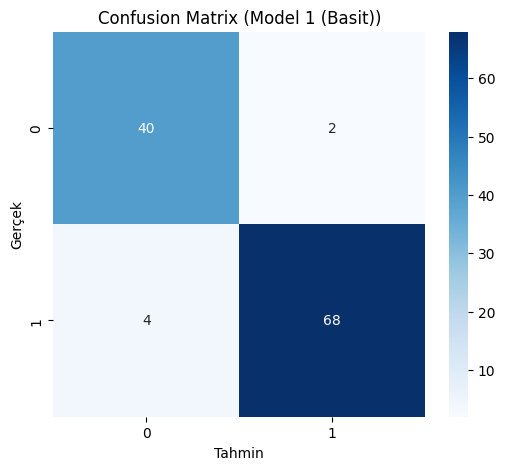

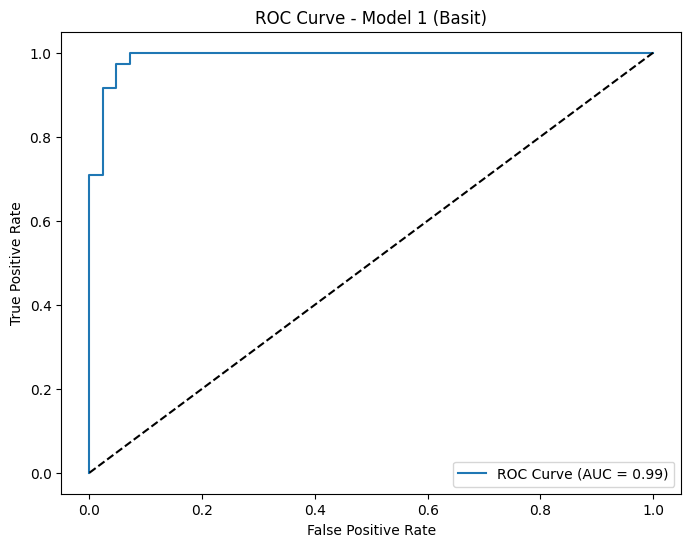

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve

# En iyi modeli seç (Örneğin F1 skoruna göre)
best_model_name = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
best_mlp = trained_models[best_model_name]
print(f"\nSeçilen En İyi Model: {best_model_name}")

# Test Seti Tahminleri
y_test_pred = best_mlp.predict(X_test)
y_test_proba = best_mlp.predict_proba(X_test)[:, 1]

# 8.1 Performans Metrikleri
print("\nTest Seti Performansı:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# 8.2 Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix ({best_model_name})")
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

# 8.3 ROC Eğrisi
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_test_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend()
plt.show()

In [ ]:
import optuna

def objective(trial):
    # 9.2 Arama Aralıkları
    hidden_layer_sizes = (
        trial.suggest_int("n_units_l1", 16, 256),
        trial.suggest_int("n_units_l2", 8, 128)
    )
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    # Model Kurulumu
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        random_state=42,
        max_iter=300
    )

    # Eğitim
    model.fit(X_train, y_train)

    # Validation Skoru
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)

    return f1

# 9.1 ve 9.3 Çalıştırma
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

# 9.4 Raporlama
print("\nEn İyi Trial Sonuçları:")
print("Değer (F1 Score):", study.best_value)
print("Parametreler:", study.best_params)

# Optuna En İyi Modelini Eğitme (XAI Analizi için lazım)
best_params = study.best_params
# Parametreleri MLP formatına uygun hale getirme (layer tuple yapısı)
layers = (best_params.pop("n_units_l1"), best_params.pop("n_units_l2"))

optuna_model = MLPClassifier(
    hidden_layer_sizes=layers,
    **best_params,
    random_state=42,
    max_iter=500
)
optuna_model.fit(X_train, y_train)

[I 2025-12-03 20:46:19,790] A new study created in memory with name: no-name-e0494035-3de0-4a26-b06f-40225725a132
[I 2025-12-03 20:46:21,425] Trial 0 finished with value: 0.972972972972973 and parameters: {'n_units_l1': 196, 'n_units_l2': 127, 'learning_rate_init': 0.0003248527917194008, 'alpha': 0.0002969395069981147, 'activation': 'relu', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.972972972972973.
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-12-03 20:46:24,404] Trial 1 finished with value: 0.9444444444444444 and parameters: {'n_units_l1': 28, 'n_units_l2': 32, 'learning_rate_init': 1.3699410659642705e-05, 'alpha': 6.451704456146469e-05, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.972972972972973.
[I 2025-12-03 20:46:24,817] Tri


En İyi Trial Sonuçları:
Değer (F1 Score): 0.9863013698630136
Parametreler: {'n_units_l1': 115, 'n_units_l2': 82, 'learning_rate_init': 0.0018746986703614117, 'alpha': 0.002809333607463685, 'activation': 'relu', 'solver': 'adam', 'batch_size': 16}


MLPClassifier(alpha=0.002809333607463685, batch_size=16,
              hidden_layer_sizes=(115, 82),
              learning_rate_init=0.0018746986703614117, max_iter=500,
              random_state=42)

SHAP Değerleri Hesaplanıyor... (Lütfen bekleyiniz)


  0%|          | 0/5 [00:00<?, ?it/s]

Format Tespiti: 3D Dizi yapısı (Başarılı ayrıştırıldı)
Grafiğe giren SHAP boyutu: (30,)

1. Summary Plot


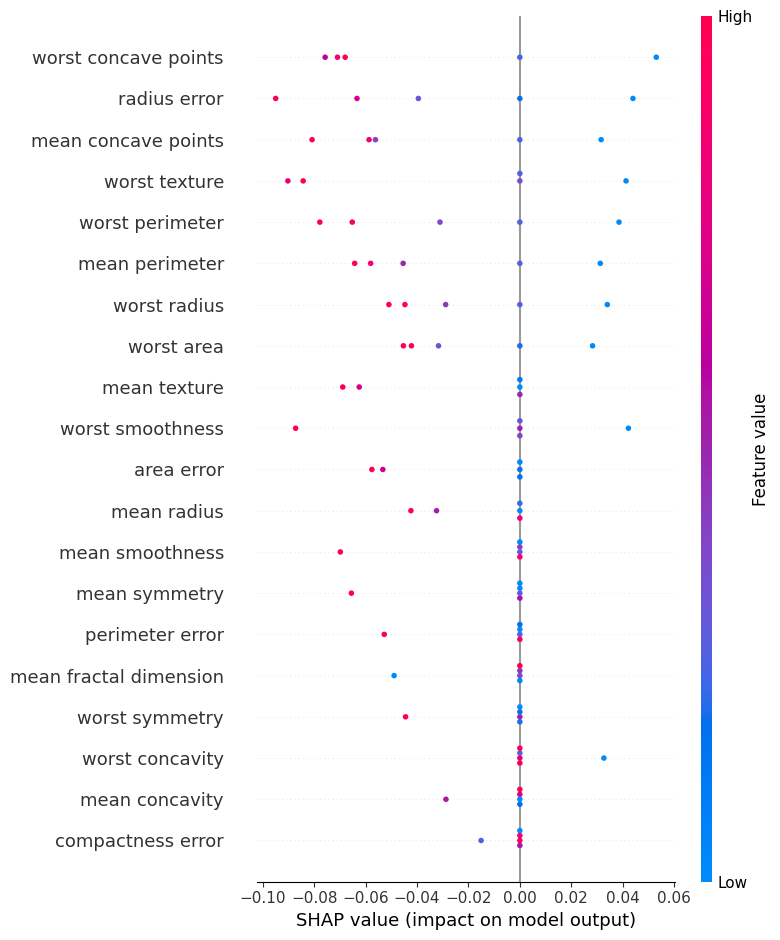


2. Bar Plot


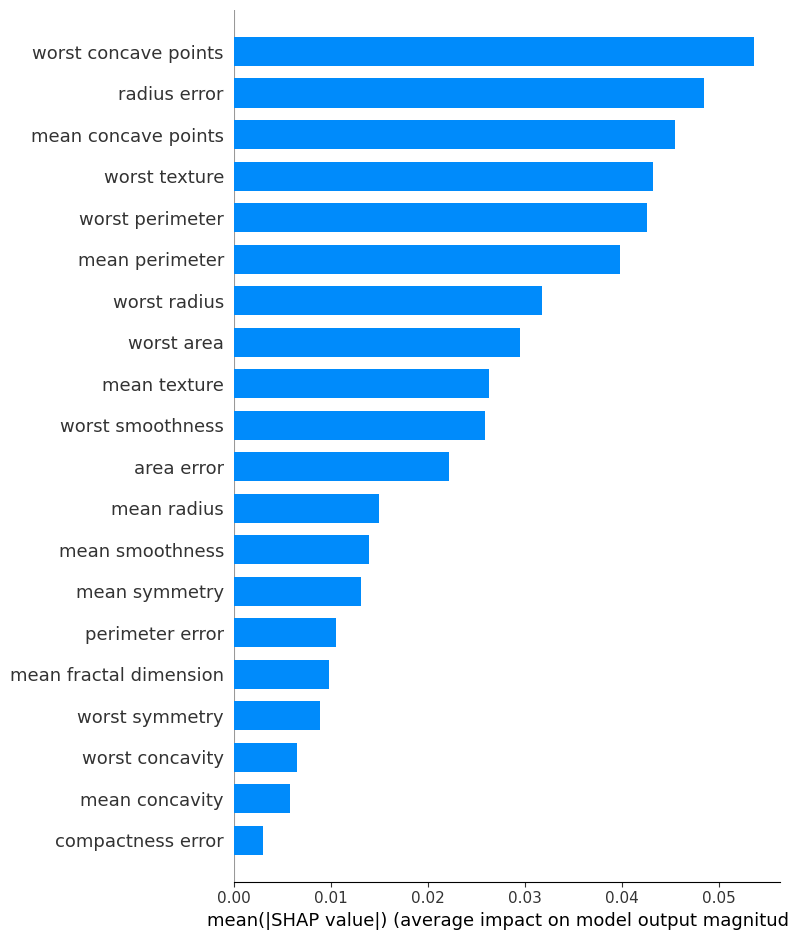


3. Waterfall Plot (Hatasız)


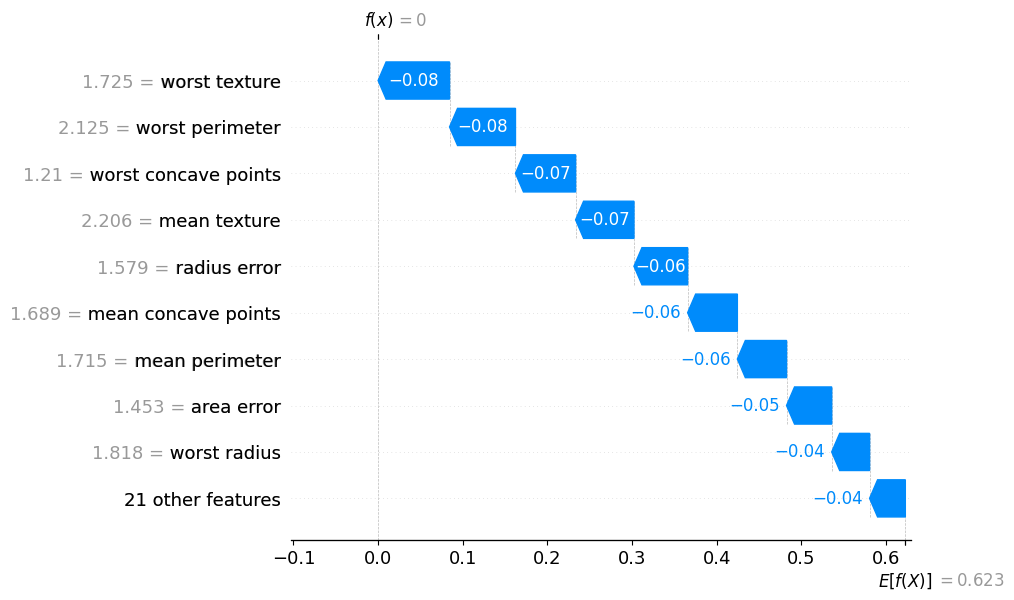


4. Decision Plot


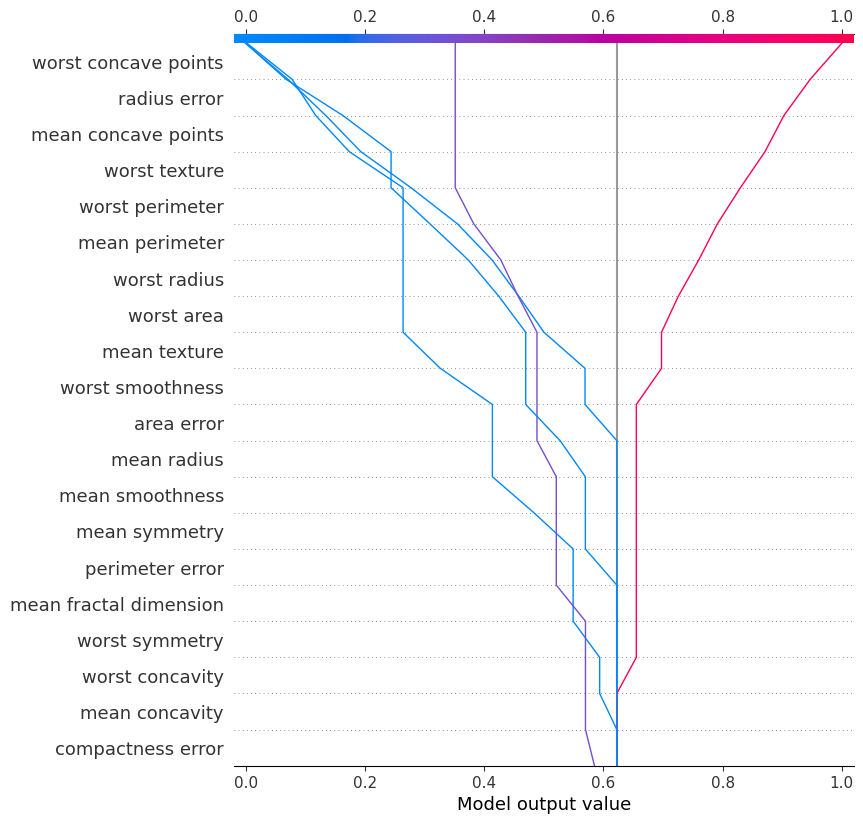

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 10. XAI - SHAP Açıklanabilirlik Analizi (Robust Versiyon) ---

# 1. Veri Hazırlığı
# Hesaplama hızı için eğitim verisini özetliyoruz
X_train_summary = shap.kmeans(X_train, 50)
# Sadece ilk 5 test verisini alıyoruz (Hızlı sonuç için)
X_test_sample = X_test.iloc[:5, :]

# 2. Explainer Oluşturma
print("SHAP Değerleri Hesaplanıyor... (Lütfen bekleyiniz)")
explainer = shap.KernelExplainer(best_mlp.predict_proba, X_train_summary)
shap_values = explainer.shap_values(X_test_sample)

# --- 3. VERİ FORMATINI DÜZELTME (HATA ÇÖZÜMÜ) ---
# KernelExplainer çıktısı bazen [dizi, dizi] listesi, bazen (N, M, 2) dizisi olabilir.
# Bizim hedefimiz: (N_samples, N_features) boyutunda Class 1 matrisi elde etmek.

if isinstance(shap_values, list):
    # Eğer liste ise: [Class0_Matrix, Class1_Matrix]
    # Class 1 (Malignant) alıyoruz
    shap_vals_class1 = shap_values[1]
    base_value = explainer.expected_value[1]
    print("Format Tespiti: Liste yapısı (Başarılı ayrıştırıldı)")

elif len(np.array(shap_values).shape) == 3:
    # Eğer 3 boyutlu dizi ise: (Örnekler, Özellikler, Sınıflar)
    # [:, :, 1] diyerek tüm örneklerin, tüm özelliklerini, sadece 1. sınıf için alıyoruz
    shap_vals_class1 = np.array(shap_values)[:, :, 1]
    base_value = explainer.expected_value[1]
    print("Format Tespiti: 3D Dizi yapısı (Başarılı ayrıştırıldı)")

else:
    # Eğer zaten 2 boyutluysa (nadiren olur)
    shap_vals_class1 = shap_values
    if isinstance(explainer.expected_value, list) or isinstance(explainer.expected_value, np.ndarray):
        base_value = explainer.expected_value[1]
    else:
        base_value = explainer.expected_value
    print("Format Tespiti: 2D Dizi yapısı")

# --- 4. TEK BİR HASTA İÇİN VERİYİ HAZIRLAMA ---
# Waterfall plot SADECE 1 boyutlu dizi ister (30,). (30, 2) veya (1, 30) kabul etmez.

row_index = 0 # İlk hasta
# .flatten() komutu olası boyut hatalarını ezer ve düz bir çizgi haline getirir
single_shap_values = shap_vals_class1[row_index].flatten()
single_data_values = X_test_sample.iloc[row_index].values.flatten()

print(f"Grafiğe giren SHAP boyutu: {single_shap_values.shape}") # (30,) olmalı

# Explanation Nesnesi Oluşturma
explanation = shap.Explanation(
    values=single_shap_values,
    base_values=float(base_value), # float() garantisi
    data=single_data_values,
    feature_names=X_test_sample.columns
)

# --- GRAFİKLER ---

print("\n1. Summary Plot")
plt.figure()
shap.summary_plot(shap_vals_class1, X_test_sample, show=True)

print("\n2. Bar Plot")
plt.figure()
shap.summary_plot(shap_vals_class1, X_test_sample, plot_type="bar", show=True)

print("\n3. Waterfall Plot (Hatasız)")
plt.figure()
shap.plots.waterfall(explanation, show=True)

print("\n4. Decision Plot")
plt.figure()
shap.decision_plot(base_value, shap_vals_class1, X_test_sample.columns, show=True)